In [1]:
import os
from random import sample
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Must be set before importing TF to supress messages
os.environ["CUDA_VISIBLE_DEVICES"]= '1'

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
import numpy as np
from utils.loader import DataLoader
from utils.tools import test_model, insert_attention_layer_in_keras
from utils.data_sampler import CustomDataGenerator, CustomIterator
from utils.configs import config
from models.layers import ProjectionAttentionLayer
from typing import List
import pymf
import pandas as pd

def load_VGG_model(img_height: int, img_width: int, lr: int, loss: tf.keras.losses.Loss, metrics: List[str], trainable: True) -> tf.keras.Model:
    """ Loads VGG-16 model.

    Args:
        img_height (int): Image height.
        img_width (int): Image width.
        lr (int): Learning rate.
        loss (tf.keras.losses.Loss): Model loss.
        metrics (List[str]): Training metrics.
        trainable (True): Set if model weights should be kept frozen or not.

    Returns:
        tf.keras.Model: TensorFlow VGG-16 model.
    """
    model = tf.keras.applications.vgg16.VGG16(input_shape=(img_height, img_width, 3))
    model.trainable = trainable
    model.compile(optimizer=tf.keras.optimizers.Adam(lr, epsilon=0.1),
                loss=loss,
                metrics=metrics)

    return model

def test_model(model, test_set: CustomIterator, class_name) -> None:
    """ Test the passed model for its Top-1 accuracy on the passed test set.

    Args:
        model (Model): TensorFlow model.
        test_set (CustomIterator): Test set to test on.
    """
    test_set.reset()
    pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    pred = np.argmax(pred, axis=-1)
    
    print('Computing accuracy...')
    accuracy = np.sum(pred == test_set.class_indices[class_name])/len(pred)

    return accuracy

In [2]:
# Set configs
img_height = 224
img_width = 224
batch_size = 128

test_datagen = CustomDataGenerator(
                preprocessing_function=tf.keras.applications.vgg16.preprocess_input, dtype=tf.float32)

# Load ImageNet dataset with the VGG augmentation
loader = DataLoader(batch_size, (img_height, img_width))
test_set = loader.load_test_set(aug_test=test_datagen, set_batch_size=False)

Loading test set...
Found 48238 images belonging to 1000 classes.


In [33]:
# Load pre-trained VGG-16 model
tf.keras.backend.clear_session()
model = tf.keras.models.load_model('models/vgg_trained')
model.trainable = False

# Get layer kernel
kernel = model.get_layer('block4_conv3').kernel
flat_kernel = tf.reshape(kernel, [-1, kernel.shape[-1]]).numpy()

In [19]:
nmf = pymf.SNMF(flat_kernel, num_bases=4)
nmf.factorize(niter=1000)
p_mat = nmf.H

In [48]:
p_mat_dict = {}

for dim in [4, 17, 42, 90, 256, 512]:
    # Get projection matrix via SNMF
    n_comp = dim

    nmf = pymf.SNMF(flat_kernel, num_bases=n_comp)
    nmf.factorize(niter=1000)
    
    # Normalise columns of W using max norm
    d = np.diag(np.max(np.abs(nmf.W), axis=0))
    p_mat = d@nmf.H

    p_mat_dict[dim] = p_mat

In [3]:
import pickle
# with open('proj_mats_norm.pkl', 'wb') as f:
#     pickle.dump(p_mat_dict, f)

In [4]:
with open('proj_mats_norm.pkl', 'rb') as f:
    p_mat_dict  = pickle.load(f)

In [5]:
classes = ['n01534433', 'n01608432', 'n01806143', 'n01820546', 'n01833805', 'n01855672', 'n02012849', 'n03887697', 'n03207941','n02906734', 'n04131690', 'n03775546', 'n04553703', 'n03207743'] 
ave = ['n01534433', 'n01608432', 'n01806143', 'n01820546', 'n01833805', 'n01855672', 'n02012849'] 
kitchen = ['n03887697', 'n03207941','n02906734', 'n04131690', 'n03775546', 'n04553703', 'n03207743']

In [ ]:
model = tf.keras.models.load_model('models/vgg_trained')
model.trainable = False
model = insert_attention_layer_in_keras(p_mat_dict[17], model, ['block5_conv1'])

model.load_weights(f'models/baseline_fixed/{17}/model_weights')
# test_set.set_target_sampling(['n01608432'], [1])
# acc_val = test_model(model, test_set, 'n01608432')
# print(acc_val) 
#b = model.get_layer('attention_block5_conv1').projection_mat
# print(np.sum(a==0)/(a.shape[0]*a.shape[1]))

In [8]:
import matplotlib.pyplot as plt

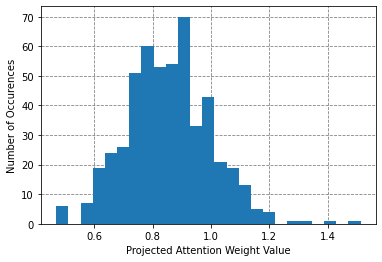

In [69]:
# a = model.get_layer('attention_block5_conv1').seeds.numpy()
# print(np.sum(a==0)/(a.shape[0]*a.shape[1]))
for dim in [256]:
    # model = tf.keras.models.load_model('models/vgg_trained')
    # model.trainable = False
    # model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    model.load_weights(f'models/task_models_fixed_test/n02906734/{dim}/model_weights')
    pj =  (model.get_layer('attention_block5_conv1').seeds@model.get_layer('attention_block5_conv1').projection_mat)+model.get_layer('attention_block5_conv1').bias
    fig2, ax2 = plt.subplots()
    ax2.set_axisbelow(True)
    ax2.yaxis.grid(color='gray', linestyle='dashed')
    ax2.xaxis.grid(color='gray', linestyle='dashed')
    ax2.hist(pj.numpy().tolist(), bins=25)
    ax2.set_xlabel('Projected Attention Weight Value')
    ax2.set_ylabel('Number of Occurences')
    #ax2.set_xlim([0, 2])
    fig2.savefig(f'ex1.png', dpi=300)

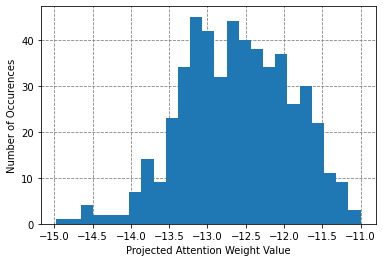

In [72]:
# a = model.get_layer('attention_block5_conv1').seeds.numpy()
# print(np.sum(a==0)/(a.shape[0]*a.shape[1]))
for dim in [256]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    # model.load_weights(f'models/task_models_fixed_test/n02906734/{dim}/model_weights')
    pj =  (model.get_layer('attention_block5_conv1').seeds@model.get_layer('attention_block5_conv1').projection_mat)+model.get_layer('attention_block5_conv1').bias
    fig2, ax2 = plt.subplots()
    ax2.set_axisbelow(True)
    ax2.yaxis.grid(color='gray', linestyle='dashed')
    ax2.xaxis.grid(color='gray', linestyle='dashed')
    ax2.hist(pj.numpy().tolist(), bins=25)
    ax2.set_xlabel('Projected Attention Weight Value')
    ax2.set_ylabel('Number of Occurences')
    #ax2.set_xlim([0, 2])
    fig2.savefig(f'ex1_before.png', dpi=300)

In [ ]:
sparsity = {}
b = [0, 40, 18, 12]
for i in [4,17,42,256,512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[i], model, ['block5_conv1'])
    model.load_weights(f'models/task_models_fixed/n03887697/{i}/model_weights')
    a = model.get_layer('attention_block5_conv1').seeds.numpy()
    sparsity[f'{i}']=np.sum(a==0)/(a.shape[0]*a.shape[1])

    pj = model.get_layer('attention_block5_conv1').seeds @ model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias
    fig2, ax2 = plt.subplots()
    ax2.set_axisbelow(True)
    ax2.yaxis.grid(color='gray', linestyle='dashed')
    ax2.xaxis.grid(color='gray', linestyle='dashed')
    ax2.hist(pj.numpy().tolist(), bins=18)
    ax2.set_xlabel('(normalised) frequency * rank')
    ax2.set_ylabel('Number of Occurences')
    #ax2.set_xlim([0, 2])
    #fig2.savefig(f'e-{i}.png')

In [59]:
# acc = pd.DataFrame(columns=['group', 'class', 4, 17, 42, 90, 256])
# acc_baseline = pd.DataFrame(columns=['group', 'class', 4, 17, 42, 90, 256])
# sparsity = pd.DataFrame(columns=['group', 'class', 4, 17, 42, 90, 256])
# ws = []

# for cl in classes:
#     acc = acc.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 4:0, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
#     acc_baseline = acc_baseline.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 4:0, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
#     sparsity = sparsity.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 4:0, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

# #Begin the tests for each class (baseline)
# for dim in [512]:
#     model = tf.keras.models.load_model('models/vgg_trained')
#     model.trainable = False
#     model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

#     model.load_weights(f'models/baseline_fixed/{dim}/model_weights')
#     for cl in classes:
#         test_set.set_target_sampling([cl], [1])
#         acc_val = test_model(model, test_set, cl)
#         acc_baseline.loc[classes.index(cl), dim] = acc_val

# Begin the tests for each class (target)
for dim in [256]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in kitchen[:3]:
        model.load_weights(f'models/task_models_fixed_test/{cl}/{str(dim)}/model_weights')
        test_set.set_target_sampling([cl], [1])
        acc_val = test_model(model, test_set, cl)
        # acc.loc[classes.index(cl), dim] = acc_val
        # a = model.get_layer('attention_block5_conv1').seeds.numpy()
        # sparsity_val = np.sum(a==0)/(a.shape[0]*a.shape[1])
        # sparsity.loc[classes.index(cl), dim] = sparsity_val
        print(acc_val)
        #ws.append(np.sum(np.where(((model.get_layer('attention_block5_conv1').seeds @ model.get_layer('attention_block5_conv1').projection_mat )+ model.get_layer('attention_block5_conv1').bias)<0)))

Computing accuracy...
0.7916666666666666
Computing accuracy...
0.7
Computing accuracy...
0.76


Sensitivity model

In [12]:
def fp_model(model, test_set: CustomIterator, cl) -> None:
    """ Test the passed model for its hit rate on the passed test set.

    Args:
        model (Model): TensorFlow model.
        test_set (CustomIterator): Test set to test on.
    """
    test_set.reset()
    pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    pred = np.argmax(pred, axis=-1)
    cls = np.array(test_set.classes)
    
    print('Computing rates...')
    not_target = np.where(cls!=test_set.class_indices[cl])[0]
    new_pred = pred[not_target]
    fp_val = np.sum(new_pred==test_set.class_indices[cl])/len(new_pred)
    accuracy = np.sum(pred == test_set.class_indices[cl])/len(pred)

    return fp_val, accuracy

In [ ]:
test_set.reset_target_sampling()
global_acc = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
global_acc_base = []
#hr_baseline = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
#fp = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
#fp_baseline = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])

for cl in classes:
    global_acc = global_acc.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
    #hr_baseline = hr_baseline.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
    #fp = fp.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
    #fp_baseline = fp_baseline.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

# Begin the tests for each class (baseline)
for dim in [512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    model.load_weights(f'models/baseline_fixed/{dim}/model_weights')

    pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    pred = np.argmax(pred, axis=-1)
    cls = np.array(test_set.classes)
    global_acc_base.append(np.sum(pred==cls))

    print('Computing rates...')
    for cl in classes:
        not_target = np.where(cls!=test_set.class_indices[cl])[0]
        new_pred = pred[not_target]
        fp_val = np.sum(new_pred==test_set.class_indices[cl])/len(new_pred)

        fp_baseline.loc[classes.index(cl), dim] = fp_val

# Begin the tests for each class (target)
for dim in [512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        #test_set.set_target_sampling([cl], [1])
        model.load_weights(f'models/task_models_fixed/{cl}/{dim}/model_weights', )
        fp_val, acc_val = fp_model(model, test_set, cl)
        fp.loc[classes.index(cl), dim] = fp_val
        global_acc.loc[classes.index(cl), dim] = acc_val

In [30]:
sparsity.to_csv('sparsity.csv', index=False)
acc.to_csv('acc.csv', index=False)
acc_baseline.to_csv('acc_baseline.csv', index=False)
fp.to_csv('false_alarm.csv', index=False)
fp_baseline.to_csv('false_alarm_base.csv', index=False)

Plots

In [11]:
dims = [17,42,90,256, 512]

In [17]:
sparsity = pd.read_csv('sparsity.csv', names=['group', 'class', 4, 17, 42, 90, 256, 512], header=0)
acc = pd.read_csv('acc.csv', names=['group', 'class', 4, 17, 42, 90, 256, 512], header=0)
acc_baseline = pd.read_csv('acc_baseline.csv', names=['group', 'class',4,  17, 42, 90, 256, 512], header=0)
fp = pd.read_csv('false_alarm.csv', names=['group', 'class', 17, 42, 90, 256, 512], header=0)
fp_baseline = pd.read_csv('false_alarm_base.csv', names=['group', 'class', 17, 42, 90, 256, 512], header=0)

In [13]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [10]:
sp_mes = np.array(sparsity[dims])
means = np.mean(sp_mes, axis=0)
errors = np.std(sp_mes, axis=0)/np.sqrt(sp_mes.shape[0]) # Compute standard error

fig = plt.figure()
ax = fig.add_subplot(111)

ax.errorbar([str(x) for x in dims], means, yerr=errors, fmt='o', color='red', ecolor='grey', elinewidth=2.5, markersize=4)
ax.grid(color='lightgrey', linestyle='-', axis='both')
ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel('Sparsity')
ax.set_ylim([0,0.8])
#fig.savefig('sparsity_per_dim.png')

print(errors)

[0.00668249 0.01312201 0.01458999 0.02179132 0.02700336] [0.03342346 0.06518139 0.0928955  0.14163048 0.16630516]


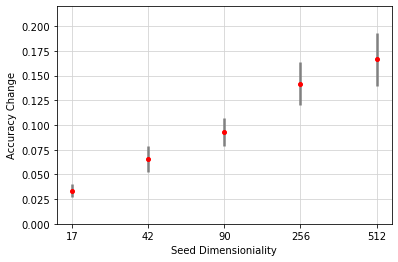

In [19]:
acc_change = np.array(acc[dims]) - np.array(acc_baseline[dims])

means = np.mean(acc_change, axis=0)
errors = np.std(acc_change, axis=0)/np.sqrt(acc_change.shape[0]) # Compute standard error

fig = plt.figure()
ax = fig.add_subplot(111)

ax.errorbar([str(x) for x in dims], means, yerr=errors, fmt='o', color='red', ecolor='grey', elinewidth=2.5, markersize=4)
ax.grid(color='lightgrey', linestyle='-', axis='both')
ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel('Accuracy Change')
ax.set_ylim([0,0.22])
fig.savefig('acc_change_per_dim.png', dpi=300)

print(errors, means)

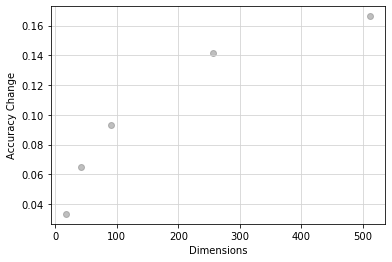

In [58]:
acc_change = np.array(acc[dims]) - np.array(acc_baseline[dims])
x = [i for i in dims]*14
x_quad = np.hstack([np.array(dims).reshape(-1, 1), np.array(dims).reshape(-1, 1)**2])
x_new = np.linspace(0, 512, 50).reshape(-1, 1)
x_new = np.hstack([x_new, x_new**2])

fig = plt.figure()
ax = fig.add_subplot(111)

reg = LinearRegression().fit(x_quad, means.reshape(-1, 1))
ax.scatter(np.array(dims).flatten(), means.flatten(), marker='o', alpha=.5, color='grey')
#ax.plot(x_new[:, 0], reg.predict(x_new), 'r', label='Linear Fit')
ax.grid(color='lightgrey', linestyle='-', axis='both')
ax.set_xlabel('Dimensions')
ax.set_ylabel('Accuracy Change')
fig.savefig('acc_change_per_all_dims.png', dpi=300)

In [ ]:
sensitivity = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
for cl in classes:
    sensitivity = sensitivity.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

hr_arr = np.array(acc[dims])
fp_arr = np.array(fp[dims])
stds_hr = np.std(hr_arr, axis=0)
means_hr= np.mean(hr_arr, axis=0)
stds_fp = np.std(fp_arr, axis=0)
means_fp= np.mean(fp_arr, axis=0)
z_hr = (hr_arr-means_hr)/stds_hr
z_fp = (fp_arr-means_fp)/stds_fp
sens = z_hr - z_fp

me_sen = np.mean(sens, axis=0)
err_sen = np.std(sens, axis=0)/np.sqrt(sens.shape[0]) # Compute standard error


fig = plt.figure()
ax = fig.add_subplot(111)

ax.errorbar([str(x) for x in dims], me_sen, yerr=err_sen, fmt='o', color='red', ecolor='grey', elinewidth=2.5, markersize=4)
ax.grid(color='lightgrey', linestyle='-', axis='both')
ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel('Accuracy Change')
#ax.set_ylim([0,0.3])
#fig.savefig('acc_change_per_dim.png')

print(errors)

Attention Weights

In [ ]:
s = {4:[],17:[], 42:[], 90:[], 256:[]}
p = {4:[],17:[], 42:[], 90:[], 256:[]}

# # Begin the tests for each class (baseline)
# for dim in [4, 17, 42, 90, 256]:
#     model = tf.keras.models.load_model('models/vgg_trained')
#     model.trainable = False
#     model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

#     model.load_weights(f'models/baseline_fixed/{dim}/model_weights')
    

# Begin the tests for each class (target)
for dim in [4, 17, 42, 90, 256]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        model.load_weights(f'models/task_models_fixed/{cl}/{dim}/model_weights')
        s[dim].extend(model.get_layer('attention_block5_conv1').seeds.numpy().tolist())
        p[dim].extend((model.get_layer('attention_block5_conv1').seeds@model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias).numpy().tolist())

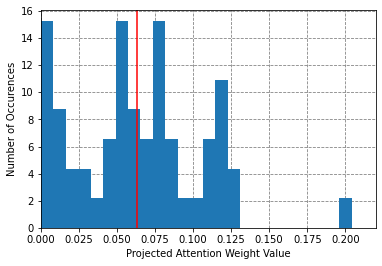

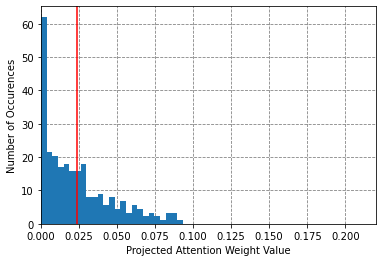

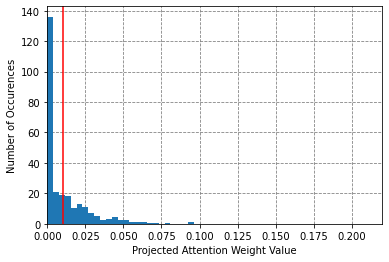

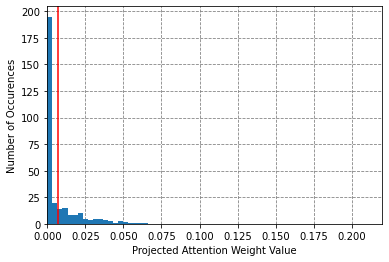

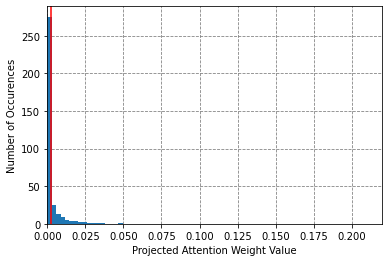

In [24]:
# for k,v in s.items():
#     s[k] = [item for sublist in v for item in sublist]

for d in dims:
    fig2, ax2 = plt.subplots()
    ax2.set_axisbelow(True)
    ax2.yaxis.grid(color='gray', linestyle='dashed')
    ax2.xaxis.grid(color='gray', linestyle='dashed')
    ax2.hist(s[d], bins=25, density=True)
    ax2.set_xlabel('Projected Attention Weight Value')
    ax2.set_ylabel('Number of Occurences')
    ax2.set_xlim([0, 0.22])
    plt.axvline(x=np.mean(s[d]), color='r')